In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Display options (optional)
pd.set_option('display.max_columns', 50)

BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/VolSurf_ML"
METRICS_DIR = os.path.join(BASE_DIR, "metrics")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [5]:
# --- Configuration ---
file_path = "/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/metrics/rnd_features_2025-12-09.parquet"

def add_asof_column(path):
    if not os.path.exists(path):
        print(f"File not found: {path}")
        return

    # 1. Load the file
    df = pd.read_parquet(path)
    print(f"Loaded {path}. Shape: {df.shape}")

    # 2. Calculate ASOF (Now minus 1 day, normalized to midnight)
    asof_date = (pd.Timestamp.now(tz='UTC') - pd.Timedelta(days=1)).normalize()

    # If you prefer naive timestamps (no timezone):
    # asof_date = (pd.Timestamp.now() - pd.Timedelta(days=1)).normalize()

    # 3. Add the column
    df['asof'] = asof_date
    print(f"Added 'asof' column with value: {asof_date}")

    # 4. Save the file (overwriting the original)
    df.to_parquet('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/metrics/rnd_features_2025-12-09.parquet')
    print("File saved successfully.")

# --- Execute ---
add_asof_column(file_path)

Loaded /content/drive/MyDrive/Colab Notebooks/VolSurf_ML/metrics/rnd_features_2025-12-09.parquet. Shape: (15, 9)
Added 'asof' column with value: 2025-12-09 00:00:00+00:00
File saved successfully.


In [14]:
# ---- Load SVI metrics ----
svi_files = sorted(glob.glob(os.path.join(METRICS_DIR, "svi_metrics_*.parquet")))
print("SVI files:")
for f in svi_files:
    print("  ", os.path.basename(f))

if not svi_files:
    raise RuntimeError("No svi_metrics_*.parquet files found in METRICS_DIR.")

svi_dfs = [pd.read_parquet(f) for f in svi_files]
svi_all = pd.concat(svi_dfs, ignore_index=True)

# Normalise types
svi_all['asof']   = pd.to_datetime(svi_all['asof'])
svi_all['expiry'] = pd.to_datetime(svi_all['expiry'])

# ---- Load SSVI metrics ----
ssvi_files = sorted(glob.glob(os.path.join(METRICS_DIR, "ssvi_metrics_*.parquet")))
print("\nSSVI files:")
for f in ssvi_files:
    print("  ", os.path.basename(f))

if not ssvi_files:
    raise RuntimeError("No ssvi_metrics_*.parquet files found in METRICS_DIR.")

ssvi_dfs = [pd.read_parquet(f) for f in ssvi_files]
ssvi_all = pd.concat(ssvi_dfs, ignore_index=True)

ssvi_all['asof']   = pd.to_datetime(ssvi_all['asof'])
ssvi_all['expiry'] = pd.to_datetime(ssvi_all['expiry'])

# ---- Merge SVI + SSVI on (asof, expiry, T) ----
# Keep only SSVI columns we care about
ssvi_cols = ['asof','expiry','T','theta','ssvi_rho','ssvi_eta','ssvi_p','fit_cost']
if 'calendar_violations' in ssvi_all.columns:
    ssvi_cols.append('calendar_violations')

metrics_all = svi_all.merge(
    ssvi_all[ssvi_cols],
    on=['asof','expiry'],
    how='left',
    suffixes=('', '_ssvi')
)

metrics_all = metrics_all.sort_values(['asof', 'T']).reset_index(drop=True)

# ---- Helper Function to Flatten Array-Wrapped Cells ----
def clean_flatten_cols(df):
    """
    Detects columns containing single-element arrays (e.g. [0.035])
    and flattens them to scalars (0.035).
    """
    for col in df.columns:
        # Skip columns that are already standard floats/ints/dates
        if pd.api.types.is_numeric_dtype(df[col]) or pd.api.types.is_datetime64_any_dtype(df[col]):
            continue

        # Check a non-null sample to see if it's an array/list
        valid_vals = df[col].dropna()
        if valid_vals.empty:
            continue

        sample = valid_vals.iloc[0]
        if isinstance(sample, (np.ndarray, list)):
            print(f"  -> Flattening array-wrapped column: {col}")
            # Extract item() if strictly numpy, or [0] if list-like
            df[col] = df[col].apply(lambda x: x.item() if hasattr(x, 'item') else (x[0] if hasattr(x, '__getitem__') and len(x) > 0 else np.nan))
            # Force to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

# ---- Load RND Features ----
rnd_files = sorted(glob.glob(os.path.join(METRICS_DIR, "rnd_features_*.parquet")))

if rnd_files:
    print(f"Found {len(rnd_files)} RND feature files.")
    rnd_dfs = [pd.read_parquet(f) for f in rnd_files]
    rnd_all = pd.concat(rnd_dfs, ignore_index=True)

    # --- STEP 1: CLEANING (The Fix) ---
    print("Cleaning RND data...")
    rnd_all = clean_flatten_cols(rnd_all)

    # --- STEP 2: DATE NORMALIZATION ---
    if 'asof' not in rnd_all.columns and 'date' in rnd_all.columns:
        rnd_all.rename(columns={'date': 'asof'}, inplace=True)

    if 'asof' in rnd_all.columns:
        rnd_all['asof'] = pd.to_datetime(rnd_all['asof'])
        if rnd_all['asof'].dt.tz is not None:
            rnd_all['asof'] = rnd_all['asof'].dt.tz_localize(None)
        rnd_all['asof'] = rnd_all['asof'].dt.normalize()

    if 'expiry' in rnd_all.columns:
        rnd_all['expiry'] = pd.to_datetime(rnd_all['expiry']).dt.normalize()

    # --- STEP 3: MERGE ---
    # Ensure metrics_all dates are also normalized for matching
    metrics_all['asof'] = pd.to_datetime(metrics_all['asof'])
    if metrics_all['asof'].dt.tz is not None:
        metrics_all['asof'] = metrics_all['asof'].dt.tz_localize(None)
    metrics_all['asof'] = metrics_all['asof'].dt.normalize()
    metrics_all['expiry'] = pd.to_datetime(metrics_all['expiry']).dt.normalize()

    # Drop 'T' from rnd to avoid duplicates/floating point mismatches
    cols_to_use = [c for c in rnd_all.columns if c != 'T']

    # Merge on Date Keys
    metrics_all = metrics_all.merge(
        rnd_all[cols_to_use],
        on=['asof', 'expiry'],
        how='left',
        suffixes=('', '_rnd')
    )

    # --- STEP 4: FILL MISSING RND ---
    # Fallback for days where RND might have failed but SVI existed
    if 'rnd_skew' in metrics_all.columns:
        metrics_all['rnd_skew'] = metrics_all['rnd_skew'].fillna(metrics_all['ATM_skew'])
    if 'rnd_kurtosis' in metrics_all.columns:
        metrics_all['rnd_kurtosis'] = metrics_all['rnd_kurtosis'].fillna(3.0)
    if 'martingale_error' in metrics_all.columns:
        # Fill missing martingale errors with a "high confidence" or "average" value?
        # Usually better to fill with 0.0 (assume okay) or the mean.
        metrics_all['martingale_error'] = metrics_all['martingale_error'].fillna(0.0)

    print(f"RND merged and cleaned. New shape: {metrics_all.shape}")
else:
    print("No RND files found.")


print("\nCombined metrics shape:", metrics_all.shape)


display(metrics_all)

SVI files:
   svi_metrics_2025-12-09.parquet
   svi_metrics_2025-12-10.parquet

SSVI files:
   ssvi_metrics_2025-12-09.parquet
   ssvi_metrics_2025-12-10.parquet
Found 2 RND feature files.
Cleaning RND data...
  -> Flattening array-wrapped column: F
  -> Flattening array-wrapped column: martingale_error
RND merged and cleaned. New shape: (38, 24)

Combined metrics shape: (38, 24)


,asof,expiry,T,ATM_IV,ATM_skew,ATM_curvature,a,b,rho,m,sigma,T_ssvi,theta,ssvi_rho,ssvi_eta,ssvi_p,fit_cost,calendar_violations,F,rnd_mean,martingale_error,rnd_vol,rnd_skew,rnd_kurtosis
0,2025-12-09,2026-01-16,0.104110,1.092347,-2.212118e+00,-4.479759e+00,0.046290,1.071568e+00,0.530463,0.154899,0.000100,0.104038,0.043449,0.999000,0.264283,0.001,0.139281,0.0,626.634314,626.634308,9.306882e-09,0.659712,0.837294,4.333870
1,2025-12-09,2026-03-20,0.276712,0.530245,2.594719e-02,-1.269696e-03,0.074269,4.135815e-02,-0.815896,-0.463713,0.000100,0.276523,0.043449,0.999000,0.264283,0.001,0.139281,0.0,630.557048,630.557042,1.053937e-08,0.404655,0.837293,4.333855
2,2025-12-09,2026-03-31,0.306849,0.364181,-7.614831e-01,-1.592218e+00,0.003615,3.544587e-01,0.519860,0.217885,0.000100,0.306639,0.043449,0.999000,0.264283,0.001,0.139281,0.0,631.244484,631.244477,1.077411e-08,0.384270,0.837293,4.333853
3,2025-12-09,2026-04-17,0.353425,0.000053,1.148455e+04,-2.479572e+12,-0.151012,5.862403e-01,0.243398,-0.069036,0.121775,0.353183,0.043449,0.999000,0.264283,0.001,0.139281,0.0,632.308359,632.308352,1.113350e-08,0.358056,0.837292,4.333848
4,2025-12-09,2026-05-15,0.430137,0.412109,2.818797e-13,1.354307e-15,0.073052,1.000000e-09,-0.999900,-0.275134,0.000100,0.429843,0.056891,0.999000,0.264283,0.001,0.139281,0.0,634.064533,634.064172,5.696272e-07,0.373816,0.975652,4.826759
5,2025-12-09,2026-06-18,0.523288,0.690391,2.767849e-09,5.182412e-16,0.249420,1.000000e-09,0.999900,-0.296802,0.000100,0.522930,0.713858,0.999000,0.264283,0.001,0.139281,0.0,636.203590,547.285568,1.397635e-01,0.927448,1.869170,6.831528
6,2025-12-09,2026-06-30,0.556164,0.173117,-1.147129e+00,-3.415838e+00,-0.062780,3.037222e+03,0.999900,0.205531,0.001518,0.555784,0.713858,0.999000,0.264283,0.001,0.139281,0.0,636.960273,547.814426,1.399551e-01,0.899113,1.867445,6.822187
7,2025-12-09,2026-09-18,0.775342,0.224056,-1.119304e-01,5.284259e-01,0.024737,3.852268e-01,-0.999900,-0.327310,0.159497,0.774812,0.713858,0.999000,0.264283,0.001,0.139281,0.0,642.027876,551.349548,1.412374e-01,0.758651,1.855963,6.760284
8,2025-12-09,2026-09-30,0.808219,0.223540,-2.598644e-01,6.411594e-01,-1.415599,7.232916e-01,0.067013,0.401524,2.000000,0.807666,0.713858,0.999000,0.264283,0.001,0.139281,0.0,642.791486,551.881226,1.414304e-01,0.742642,1.854244,6.751055
9,2025-12-09,2026-12-18,1.024658,0.000031,1.201260e+03,-4.619156e+10,-1.756170,4.966146e+00,0.694049,0.433681,0.469459,1.023956,0.713858,0.999000,0.264283,0.001,0.139281,0.0,647.841306,555.390599,1.427058e-01,0.657120,1.842949,6.690653


In [15]:
price_path = os.path.join(BASE_DIR, "hist_price.parquet")
prices = pd.read_parquet(price_path)

# Ensure index is sorted
prices = prices.sort_index()

# If index is timezone-aware (like 2023-11-15 00:00:00-05:00), drop tz
if hasattr(prices.index, "tz") and prices.index.tz is not None:
    # Option 1: convert to UTC then drop tz
    prices.index = prices.index.tz_convert("UTC").tz_localize(None)
    # Option 2 (simpler, also fine here): prices.index = prices.index.tz_localize(None)

# Basic returns and realised vol
prices['return_1d'] = prices['Close'].pct_change()
prices['return_5d'] = prices['Close'].pct_change(5)
prices['rv_20d']    = prices['return_1d'].rolling(20).std() * np.sqrt(252)

# Turn index into a column called 'asof' (date-like, no tz)
prices = prices.reset_index().rename(columns={prices.index.name or 'Date': 'asof'})
prices['asof'] = pd.to_datetime(prices['asof']).dt.normalize()

prices.tail()

,asof,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,return_1d,return_5d,rv_20d
496,2025-12-03,619.619995,624.219971,618.030029,623.520020,47841600,0.0,0.0,0.0,0.002444,0.024027,0.202712
497,2025-12-04,624.929993,624.940002,619.539978,622.940002,47067800,0.0,0.0,0.0,-0.000930,0.014114,0.201466
498,2025-12-05,624.380005,628.919983,623.710022,625.479980,53614200,0.0,0.0,0.0,0.004077,0.010061,0.189302
499,2025-12-08,627.210022,628.840027,621.690002,624.280029,43462400,0.0,0.0,0.0,-0.001918,0.011520,0.188977
500,2025-12-09,623.010010,625.869995,621.000000,625.049988,37092100,0.0,0.0,0.0,0.001233,0.004904,0.172167


In [16]:
df = metrics_all.merge(
    prices[['asof', 'Close', 'return_1d', 'return_5d', 'rv_20d']],
    on='asof',
    how='left'
)

df = df.rename(columns={'Close': 'spot'})
df = df.sort_values(['T', 'asof']).reset_index(drop=True)

print("Merged shape:", df.shape)
df.tail()


Merged shape: (38, 28)


,asof,expiry,T,ATM_IV,ATM_skew,ATM_curvature,a,b,rho,m,sigma,T_ssvi,theta,ssvi_rho,ssvi_eta,ssvi_p,fit_cost,calendar_violations,F,rnd_mean,martingale_error,rnd_vol,rnd_skew,rnd_kurtosis,spot,return_1d,return_5d,rv_20d
33,2025-12-09,2027-09-17,1.772603,17.294635,18.718348,-20.240256,-0.094461,1.147948e+07,-0.999900,-0.461836,0.000100,1.771389,0.713858,0.999000,0.264283,0.001,0.139281,0.0,665.599344,567.640104,0.147174,0.493225,1.804208,6.486666,625.049988,0.001233,0.004904,0.172167
34,2025-12-10,2027-12-17,2.019178,0.235400,-0.116240,0.232430,-0.033185,1.975989e-01,-0.506912,0.037411,0.714243,2.017796,0.113448,-0.537635,1.074905,0.500,0.000306,0.0,672.577925,676.328177,0.005576,0.242211,0.036543,4.325949,NaN,NaN,NaN,NaN
35,2025-12-09,2027-12-17,2.021918,0.171370,0.380799,-0.846100,0.046850,5.179687e-01,-0.490525,-0.047479,0.000100,2.020534,0.713858,0.999000,0.264283,0.001,0.139281,0.0,671.626209,571.765248,0.148685,0.459836,1.791394,6.420275,625.049988,0.001233,0.004904,0.172167
36,2025-12-10,2028-01-21,2.115068,0.230635,-0.099624,0.869198,0.070606,1.932098e-01,-0.257135,0.050158,0.197700,2.113621,0.119685,-0.537635,1.074905,0.500,0.000306,NaN,674.922814,679.162301,0.006281,0.242283,0.073376,4.318670,NaN,NaN,NaN,NaN
37,2025-12-09,2028-01-21,2.117808,0.242432,-0.606446,0.299847,-0.918781,4.342558e+00,0.713544,0.529870,0.318689,2.116359,0.713858,0.999000,0.264283,0.001,0.139281,NaN,673.958738,573.357414,0.149269,0.448562,1.786478,6.394951,625.049988,0.001233,0.004904,0.172167


In [17]:
df = df.sort_values(['T', 'asof']).reset_index(drop=True)

# Shift ATM_IV one day ahead within each tenor
df['ATM_IV_tplus1'] = df.groupby('T')['ATM_IV'].shift(-1)

missing_mask = df['ATM_IV_tplus1'].isna()
df.loc[missing_mask, 'ATM_IV_tplus1'] = df.loc[missing_mask, 'ATM_IV']

print("After creating target, shape:", df.shape)
df[['asof', 'T', 'ATM_IV', 'ATM_IV_tplus1']].tail(10)


After creating target, shape: (38, 29)


,asof,T,ATM_IV,ATM_IV_tplus1
28,2025-12-10,1.098630,0.249145,0.249145
29,2025-12-09,1.101370,0.527817,0.527817
30,2025-12-10,1.517808,0.228693,0.228693
31,2025-12-09,1.520548,0.189173,0.189173
32,2025-12-10,1.769863,0.226966,0.226966
33,2025-12-09,1.772603,17.294635,17.294635
34,2025-12-10,2.019178,0.235400,0.235400
35,2025-12-09,2.021918,0.171370,0.171370
36,2025-12-10,2.115068,0.230635,0.230635
37,2025-12-09,2.117808,0.242432,0.242432


In [18]:
feature_cols = [
    'T',
    # ATM + SVI
    'ATM_IV', 'ATM_skew', 'ATM_curvature',
    'a', 'b', 'rho', 'm', 'sigma',
    # SSVI
    'theta', 'ssvi_rho', 'ssvi_eta', 'ssvi_p',

    #RND

    'rnd_vol', 'rnd_skew', "rnd_kurtosis", 'martingale_error',
    # optional: calendar / fit diagnostics
    # 'fit_cost',
    # 'calendar_violations',
    # market features (when merge_asof is fixed)
     'return_1d', 'rv_20d'
]

target_col = 'ATM_IV_tplus1'

data = df.dropna(subset=feature_cols + [target_col]).copy()
data = data.sort_values('asof').reset_index(drop=True)

print("Final usable rows:", len(data))
data[ ['asof', 'T', 'ATM_IV', 'ATM_IV_tplus1'] + feature_cols ].head()


Final usable rows: 15


,asof,T,ATM_IV,ATM_IV_tplus1,T,ATM_IV,ATM_skew,ATM_curvature,a,b,rho,m,sigma,theta,ssvi_rho,ssvi_eta,ssvi_p,rnd_vol,rnd_skew,rnd_kurtosis,martingale_error,return_1d,rv_20d
0,2025-12-09,0.104110,1.092347,1.092347,0.104110,1.092347,-2.212118e+00,-4.479759e+00,0.046290,1.071568e+00,0.530463,0.154899,0.000100,0.043449,0.999,0.264283,0.001,0.659712,0.837294,4.333870,9.306882e-09,0.001233,0.172167
1,2025-12-09,0.276712,0.530245,0.530245,0.276712,0.530245,2.594719e-02,-1.269696e-03,0.074269,4.135815e-02,-0.815896,-0.463713,0.000100,0.043449,0.999,0.264283,0.001,0.404655,0.837293,4.333855,1.053937e-08,0.001233,0.172167
2,2025-12-09,0.306849,0.364181,0.364181,0.306849,0.364181,-7.614831e-01,-1.592218e+00,0.003615,3.544587e-01,0.519860,0.217885,0.000100,0.043449,0.999,0.264283,0.001,0.384270,0.837293,4.333853,1.077411e-08,0.001233,0.172167
3,2025-12-09,0.353425,0.000053,0.000053,0.353425,0.000053,1.148455e+04,-2.479572e+12,-0.151012,5.862403e-01,0.243398,-0.069036,0.121775,0.043449,0.999,0.264283,0.001,0.358056,0.837292,4.333848,1.113350e-08,0.001233,0.172167
4,2025-12-09,0.430137,0.412109,0.412109,0.430137,0.412109,2.818797e-13,1.354307e-15,0.073052,1.000000e-09,-0.999900,-0.275134,0.000100,0.056891,0.999,0.264283,0.001,0.373816,0.975652,4.826759,5.696272e-07,0.001233,0.172167


In [19]:
n = len(data)
if n < 30:
    print("⚠️ Warning: very few samples for ML. The notebook will run, but forecasting quality will be limited until you collect more days.")

train_end = int(n * 0.7)
val_end   = int(n * 0.85)

train = data.iloc[:train_end]
val   = data.iloc[train_end:val_end]
test  = data.iloc[val_end:]

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

X_train = train[feature_cols].values.astype(np.float32)
y_train = train[target_col].values.astype(np.float32)

X_val   = val[feature_cols].values.astype(np.float32)
y_val   = val[target_col].values.astype(np.float32)

X_test  = test[feature_cols].values.astype(np.float32)
y_test  = test[target_col].values.astype(np.float32)

dates_test = test['asof'].values

def get_weights(df, col='martingale_error', scale=100.0):
  err = df[col].fillna(df[col].mean()).values.astype(np.float32)
  return 1.0 / (1.0 + scale *err)

w_train = get_weights(train)
w_val = get_weights(val)
w_test = get_weights(test)


⚠️ Warning: very few samples for ML. The notebook will run, but forecasting quality will be limited until you collect more days.
Train: 10, Val: 2, Test: 3


In [20]:
if len(test) > 0:
    y_pred_persist = test['ATM_IV'].values.astype(np.float32)

    mae_persist = mean_absolute_error(y_test, y_pred_persist)
    rmse_persist = mean_squared_error(y_test, y_pred_persist)
    print(f"Baseline (persistence) – MAE: {mae_persist:.6f}, RMSE: {rmse_persist:.6f}")
else:
    print("No test set; cannot compute baseline yet.")


Baseline (persistence) – MAE: 0.000000, RMSE: 0.000000


In [22]:
def make_loader(X, y, w, batch_size=64, shuffle=False):
    X_tensor = torch.from_numpy(X)
    y_tensor = torch.from_numpy(y).unsqueeze(1)  # (N,) -> (N,1)
    w_tensor = torch.from_numpy(w).unsqueeze(1) #match y shape
    ds = TensorDataset(X_tensor, y_tensor, w_tensor)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, w_train, batch_size=64, shuffle=True)
val_loader   = make_loader(X_val,   y_val, w_val, batch_size=256, shuffle=False)
test_loader  = make_loader(X_test,  y_test,  w_test, batch_size=256, shuffle=False)


In [23]:
input_dim = X_train.shape[1]

class VolForecastNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        # x shape: (batch_size, input_dim)

        # Layer 1: Linear -> BatchNorm -> ReLU
        x = self.fc1(x)
        x = self.bn1(x)   # <-- BatchNorm applied here
        x = self.act(x)

        # Layer 2: Linear -> BatchNorm -> ReLU
        x = self.fc2(x)
        x = self.bn2(x)   # <-- BatchNorm applied here
        x = self.act(x)

        # Output layer: Linear (no BatchNorm, no activation)
        x = self.fc3(x)
        return x

model = VolForecastNet(input_dim).to(device)
criterion = nn.HuberLoss(delta=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model


VolForecastNet(
  (fc1): Linear(in_features=19, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (act): ReLU()
)

In [24]:
best_val_loss = float('inf')
best_state = None
patience = 10
patience_counter = 0

train_history = []
val_history = []

for epoch in range(100):  # max epochs
    # ---- Train ----
    model.train()
    batch_losses = []
    for xb, yb, wb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        wb = wb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        raw_loss = (preds-yb)**2
        weighted_loss = raw_loss * wb
        loss = weighted_loss.mean()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    train_loss = np.mean(batch_losses)

    # ---- Validate ----
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb, wb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            wb = wb.to(device)
            preds = model(xb)
            val_loss_batch = (wb*(preds-yb)**2).mean()
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses) if val_losses else np.nan

    train_history.append(train_loss)
    val_history.append(val_loss)

    print(f"Epoch {epoch:03d} | train {train_loss:.6f} | val {val_loss:.6f}")

    # Early stopping
    if val_losses and val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        best_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break

# Load best model (if we have one)
if best_state is not None:
    model.load_state_dict(best_state)


Epoch 000 | train 0.257320 | val 0.257320
Epoch 001 | train 0.239292 | val 0.239292
Epoch 002 | train 0.187769 | val 0.187769
Epoch 003 | train 0.177711 | val 0.177711
Epoch 004 | train 0.169560 | val 0.169560
Epoch 005 | train 0.144235 | val 0.144235
Epoch 006 | train 0.138355 | val 0.138355
Epoch 007 | train 0.153765 | val 0.153765
Epoch 008 | train 0.129306 | val 0.129306
Epoch 009 | train 0.134121 | val 0.134121
Epoch 010 | train 0.127957 | val 0.127957
Epoch 011 | train 0.126035 | val 0.126035
Epoch 012 | train 0.116378 | val 0.116378
Epoch 013 | train 0.112017 | val 0.112017
Epoch 014 | train 0.109397 | val 0.109397
Epoch 015 | train 0.102840 | val 0.102840
Epoch 016 | train 0.096708 | val 0.096708
Epoch 017 | train 0.101164 | val 0.101164
Epoch 018 | train 0.088013 | val 0.088013
Epoch 019 | train 0.086144 | val 0.086144
Epoch 020 | train 0.131682 | val 0.131682
Epoch 021 | train 0.132793 | val 0.132793
Epoch 022 | train 0.132827 | val 0.132827
Epoch 023 | train 0.130313 | val 0

In [27]:
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for xb, yb, wb in test_loader:
        xb = xb.to(device)

        # Get raw model predictions
        preds = model(xb).cpu().numpy().ravel()
        y_pred_list.append(preds)
        y_true_list.append(yb.numpy().ravel())

if y_pred_list:
    y_pred_nn = np.concatenate(y_pred_list)
    y_true_eval = np.concatenate(y_true_list) # Use targets from loader to ensure alignment

    # Calculate metrics
    mae_nn = mean_absolute_error(y_true_eval, y_pred_nn)
    rmse_nn = mean_squared_error(y_true_eval, y_pred_nn)

    print(f"PyTorch MLP – MAE: {mae_nn:.6f}, RMSE: {rmse_nn:.6f}")

    # Optional: Compare with persistence if available
    if 'mae_persist' in locals():
        print(f"Baseline     – MAE: {mae_persist:.6f}, RMSE: {rmse_persist:.6f}")
else:
    print("No predictions from test_loader (probably empty test set).")

PyTorch MLP – MAE: 5.713337, RMSE: 97.117401
Baseline     – MAE: 0.000000, RMSE: 0.000000


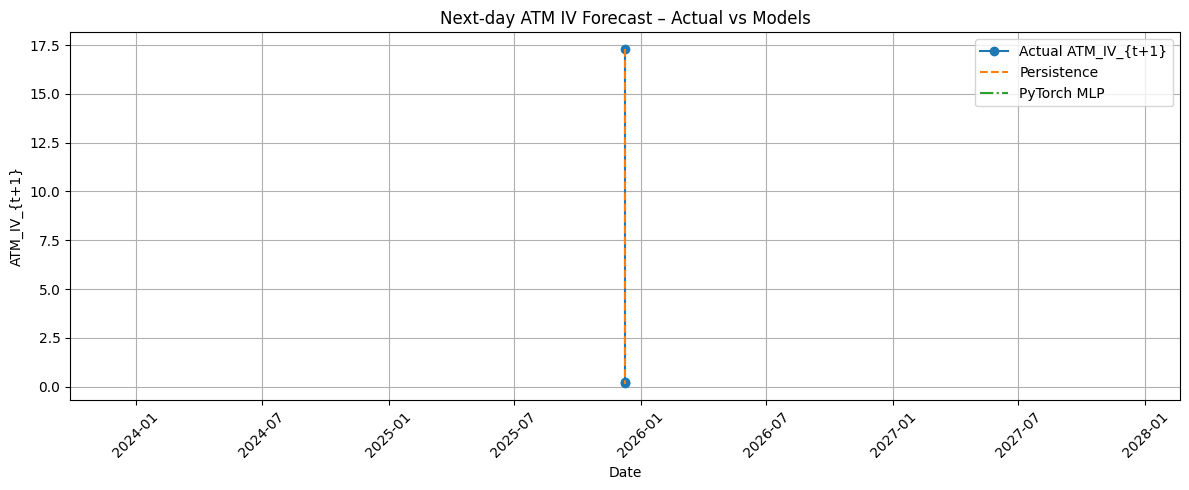

In [28]:
if len(test) > 0 and y_pred_list:
    plt.figure(figsize=(12,5))
    plt.plot(dates_test, y_test, label='Actual ATM_IV_{t+1}', marker='o')
    plt.plot(dates_test, y_pred_persist, label='Persistence', linestyle='--')
    plt.plot(dates_test, y_pred_nn, label='PyTorch MLP', linestyle='-.')
    plt.xlabel("Date")
    plt.ylabel("ATM_IV_{t+1}")
    plt.title("Next-day ATM IV Forecast – Actual vs Models")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough test data to plot.")
